##**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##**Data Collection and Description**

In [ ]:
df = pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")

In [ ]:
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [ ]:
df.shape

(42, 2)

In [ ]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

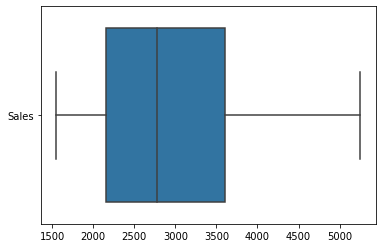

In [ ]:
sns.boxplot(data=df,orient="h")

In [ ]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [ ]:
quarter =['Q1','Q2','Q3','Q4']

In [ ]:
p = df["Quarter"][0]
p[0:2]
df['quarter']= 0

for i in range(42):
    p = df["Quarter"][i]
    df['quarter'][i]= p[0:2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [ ]:
quarter_dummies = pd.DataFrame(pd.get_dummies(df['quarter']))
CocaCola = pd.concat([df,quarter_dummies],axis = 1)
CocaCola.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [ ]:
CocaCola["t"] = np.arange(1,43)   
CocaCola["t_squared"] = CocaCola["t"]*CocaCola["t"] # for ploynomial/quadratic trend
CocaCola["log_Sales"] = np.log(CocaCola["Sales"]) # For multiplicative seasonality
CocaCola.columns

Index(['Quarter', 'Sales', 'quarter', 'Q1', 'Q2', 'Q3', 'Q4', 't', 't_squared',
       'log_Sales'],
      dtype='object')

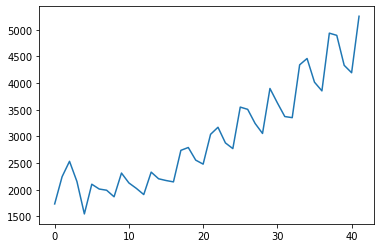

In [ ]:
CocaCola.Sales.plot()
plt.show()

In [ ]:
#splitting train and test data
Train = CocaCola.head(34)
Test = CocaCola.tail(8)

In [ ]:
#Linear
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


RMSE Linear:  720.6137817965266


In [ ]:
#Exponential
Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  564.9850937274324


In [ ]:
#Quadratic
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  437.7455637558651


In [ ]:
#Additive Seasonality
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1', 'Q2', 'Q3', 'Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  1870.1899069853293


In [ ]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1', 'Q2', 'Q3', 'Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 257.6717256536323


In [ ]:
# Multiplicative Seasonality
Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 1940.8042499186563


In [ ]:
#Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea)

RMSE Multiplicative Additive Seasonality: 400.42004584361683


In [ ]:
#Tabulizing the values
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,720.613782
1,rmse_Exp,564.985094
2,rmse_Quad,437.745564
3,rmse_add_sea,1870.189907
4,rmse_add_sea_quad,257.671726
5,rmse_Mult_sea,1940.804250
6,rmse_Mult_add_sea,400.420046


In [ ]:
#forcasting for next 4 quarter
df = [['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'],['Q2_97', 'Q2']]
print(df)
forecast = pd.DataFrame(df, columns = ['Quarter', 'quarter'])
forecast

[['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'], ['Q2_97', 'Q2']]


,Quarter,quarter
0,Q3_96,Q3
1,Q4_96,Q4
2,Q1_97,Q1
3,Q2_97,Q2


In [ ]:
dummies = pd.DataFrame(pd.get_dummies(forecast['quarter']))
forecast1 = pd.concat([forecast,dummies],axis = 1)
print("After dummy\n",forecast1.head())

forecast1["t"] = np.arange(1,5)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter T and T-Square\n",forecast1.head())

After dummy
   Quarter quarter  Q1  Q2  Q3  Q4
0   Q3_96      Q3   0   0   1   0
1   Q4_96      Q4   0   0   0   1
2   Q1_97      Q1   1   0   0   0
3   Q2_97      Q2   0   1   0   0

After T and T-Square
   Quarter quarter  Q1  Q2  Q3  Q4  t  t_squared
0   Q3_96      Q3   0   0   1   0  1          1
1   Q4_96      Q4   0   0   0   1  2          4
2   Q1_97      Q1   1   0   0   0  3          9
3   Q2_97      Q2   0   1   0   0  4         16


In [ ]:
# Forecasting using Additive Seasonality Quadratic Model
model = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=CocaCola).fit()
pred_new  = pd.Series(model.predict(forecast1))
pred_new

forecast1["forecasted_sales"] = pd.Series(pred_new)

In [ ]:
#Final sales Prediction
Final_predict = forecast1.loc[:, ['Quarter', 'forecasted_sales']] 
Final_predict

,Quarter,forecasted_sales
0,Q3_96,2180.858824
1,Q4_96,1851.383709
2,Q1_97,1635.419724
3,Q2_97,2284.261547


# **Airlines Forecasting**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel("/content/Airlines+Data.xlsx")

In [ ]:
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [ ]:
df.shape

(96, 2)

In [ ]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df['months'] = df['Month'].dt.strftime('%b')
df.tail()

,Month,Passengers,months
91,2002-08-01,405,Aug
92,2002-09-01,355,Sep
93,2002-10-01,306,Oct
94,2002-11-01,271,Nov
95,2002-12-01,306,Dec


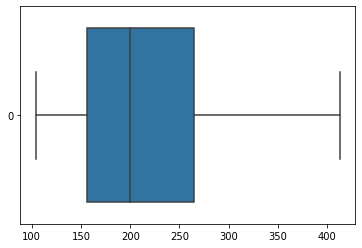

In [ ]:
sns.boxplot(data=df['Passengers'],orient="h")

In [ ]:
months =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [ ]:
#creating dummy values
month_dummies = pd.DataFrame(pd.get_dummies(df['months']))
airline = pd.concat([df,month_dummies],axis = 1)
airline.head()

,Month,Passengers,months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
airline["t"] = np.arange(1,97)   
airline["t_squared"] = airline["t"]*airline["t"] 
airline["log_Passengers"] = np.log(airline["Passengers"])
airline.columns

Index(['Month', 'Passengers', 'months', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan',
       'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 't', 't_squared',
       'log_Passengers'],
      dtype='object')

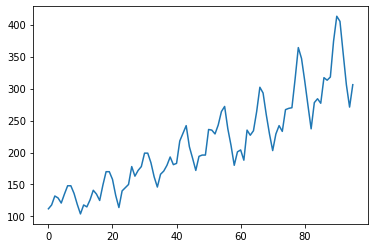

In [ ]:
airline.Passengers.plot()
plt.show()

In [ ]:
Train = airline.head(72)
Test = airline.tail(24)

In [ ]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  51.667792995646266


In [ ]:
#Exponential
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  42.55232894600461


In [ ]:
#Quadratic
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  51.9907364015548


In [ ]:
#Additive Seasonality
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  127.2645156532034


In [ ]:
#Additive Seasonality Quadratic
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 35.24160848592679


In [ ]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 132.18762800263443


In [ ]:
#Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 11.714670246780832


In [ ]:
df = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(df)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,51.667793
1,rmse_Exp,42.552329
2,rmse_Quad,51.990736
3,rmse_add_sea,127.264516
4,rmse_add_sea_quad,35.241608
5,rmse_Mult_sea,132.187628
6,rmse_Mult_add_sea,11.714670


In [ ]:
#prediction for 12 months
df = [['2003-01-01', 'Jan'], ['2003-02-01', 'Feb'], ['2003-03-01', 'Mar'],['2003-04-01', 'Apr'],['2003-5-01', 'May'],['2003-06-01', 'Jun'],
        ['2003-07-01', 'Jul'],['2003-08-01', 'Aug'],['2003-09-01', 'Sep'],['2003-10-01', 'Oct'],['2003-11-01', 'Nov'],['2003-12-01', 'Dec']]
# print(data)
forecast = pd.DataFrame(df, columns = ['Date', 'Months'])
forecast

,Date,Months
0,2003-01-01,Jan
1,2003-02-01,Feb
2,2003-03-01,Mar
3,2003-04-01,Apr
4,2003-5-01,May
5,2003-06-01,Jun
6,2003-07-01,Jul
7,2003-08-01,Aug
8,2003-09-01,Sep
9,2003-10-01,Oct


In [ ]:
dummies = pd.DataFrame(pd.get_dummies(forecast['Months']))
forecast1 = pd.concat([forecast,dummies],axis = 1)
print("After dummy\n",forecast1.head())

forecast1["t"] = np.arange(1,13)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter T and T-Square\n",forecast1.head())

After dummy
          Date Months  Apr  Aug  Dec  Feb  ...  Jun  Mar  May  Nov  Oct  Sep
0  2003-01-01    Jan    0    0    0    0  ...    0    0    0    0    0    0
1  2003-02-01    Feb    0    0    0    1  ...    0    0    0    0    0    0
2  2003-03-01    Mar    0    0    0    0  ...    0    1    0    0    0    0
3  2003-04-01    Apr    1    0    0    0  ...    0    0    0    0    0    0
4   2003-5-01    May    0    0    0    0  ...    0    0    1    0    0    0

[5 rows x 14 columns]

After T and T-Square
          Date Months  Apr  Aug  Dec  Feb  ...  May  Nov  Oct  Sep  t  t_squared
0  2003-01-01    Jan    0    0    0    0  ...    0    0    0    0  1          1
1  2003-02-01    Feb    0    0    0    1  ...    0    0    0    0  2          4
2  2003-03-01    Mar    0    0    0    0  ...    0    0    0    0  3          9
3  2003-04-01    Apr    1    0    0    0  ...    0    0    0    0  4         16
4   2003-5-01    May    0    0    0    0  ...    1    0    0    0  5         25

[5 r

In [ ]:
#Forecasting using Multiplicative Additive Seasonality Model

model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =airline).fit()
pred_new  = pd.Series(model_full.predict(forecast1))
pred_new

forecast1["Forecasted_log"] = pd.Series(pred_new)
forecast1['Forecasted_Passengers'] = np.exp(forecast1['Forecasted_log'])

In [ ]:
#Prediction
Final_predict = forecast1.loc[:, ['Months', 'Forecasted_Passengers']] 
Final_predict

,Months,Forecasted_Passengers
0,Jan,109.176148
1,Feb,110.331245
2,Mar,127.315234
3,Apr,123.200587
4,May,122.399578
5,Jun,138.536397
6,Jul,154.066959
7,Aug,153.741209
8,Sep,137.693733
9,Oct,120.894736
